Projet 5 | Catégorisez automatiquement des questions

Partie 4.1 | Analyse Supervisée - Word2Vec

# Présentation du projet
Nous cherchons a aider la communauté de Stack Overflow, site célèbre de questions-réponses liées au développement informatique, en réalisant un API de prédiction de tags.<br/>
L'analyse se basera sur le NLP (Natural language processing) et nous testerons différentes méthodes pour ne sélectionner que la plus efficace et pertinente.

# Import des packages, fonctions et paramétrage initial

## Librairies

In [1]:
# Modules classiques d'analyse exploratoire:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## MLFlow

In [2]:
!pip install mlflow --quiet
!pip install pyngrok --quiet

In [3]:
# check wether mlflow is installed
!mlflow

Usage: mlflow [OPTIONS] COMMAND [ARGS]...

Options:
  --version  Show the version and exit.
  --help     Show this message and exit.

Commands:
  artifacts    Upload, list, and download artifacts from an MLflow...
  db           Commands for managing an MLflow tracking database.
  deployments  Deploy MLflow models to custom targets.
  doctor       Prints out useful information for debugging issues with MLflow.
  experiments  Manage experiments.
  gc           Permanently delete runs in the `deleted` lifecycle stage.
  models       Deploy MLflow models locally.
  recipes      Run MLflow Recipes and inspect recipe results.
  run          Run an MLflow project from the given URI.
  runs         Manage runs.
  sagemaker    Serve models on SageMaker.
  server       Run the MLflow tracking server.


C:\Users\A475388\AppData\Local\anaconda3\Lib\site-packages\pydantic\_internal\_config.py:334: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


In [4]:
import mlflow
from mlflow.tracking import MlflowClient
import mlflow.sklearn

mlflow.set_experiment('IMLP5-Supervisé')

<Experiment: artifact_location='file:///C:/Users/A475388/Notebooks/IML%20P5/mlruns/426218426788538168', creation_time=1716554842266, experiment_id='426218426788538168', last_update_time=1716554842266, lifecycle_stage='active', name='IMLP5-Supervisé', tags={}>

In [5]:
print(mlflow.__version__)

2.12.1


## Chargement du dataset

In [6]:
# Création des DataFrame
df_stack = pd.read_csv("C:/Users/A475388/OneDrive - Volvo Group/Z_Perso/IML/IML P5/QueryResults.csv")
df_stack['txt'] = df_stack['Title'] + '-' + df_stack['Body']
df_stack.head(1)

,Title,Body,Tags,CreationDate,AnswerCount,ViewCount,Score,txt
0,Python kernel dies for second run of PyQt5 GUI,<ul>\n<li>Using Spyder in Python 3.5.2 |Anacon...,<python><ipython><anaconda><pyqt5><spyder>,2016-10-17 19:21:55,3,10077,17,Python kernel dies for second run of PyQt5 GUI...


In [7]:
# Import df préprocess
df_cleaned = pd.read_csv("/Users/A475388/OneDrive - Volvo Group/Z_Perso/IML/IML P5/df_cleaned.csv",
                 sep=';')
df_cleaned.sample(1)

,Title,Body,Tags,lemmatized_corpus,lemmatized_tags,stemmed_corpus,stemmed_tags
24237,Twitter Bootstrap modal opening/closing causes...,<p>I am almost done with a simple 2-page websi...,<css><twitter-bootstrap><dialog><modal-dialog>...,"['twitter', 'bootstrap', 'modal', 'opening', '...","['twitter', 'bootstrap', 'dialog', 'modal', 'd...","['twitter', 'bootstrap', 'modal', 'open', 'clo...","['twitter', 'bootstrap', 'dialog', 'modal', 'd..."


In [8]:
import ast
df_cleaned['lemmatized_corpus'] = df_cleaned['lemmatized_corpus'].map(
    lambda x: ast.literal_eval(x)
)
df_cleaned['lemmatized_tags'] = df_cleaned['lemmatized_tags'].map(
    lambda x: ast.literal_eval(x)
)
df_cleaned['stemmed_corpus'] = df_cleaned['stemmed_corpus'].map(
    lambda x: ast.literal_eval(x)
)
df_cleaned['stemmed_tags'] = df_cleaned['stemmed_tags'].map(
    lambda x: ast.literal_eval(x)
)

In [9]:
df_cleaned['Text_complet'] = df_cleaned['Title'] + df_cleaned['Body']
df_cleaned['Text_complet'].head(1)

0    Python kernel dies for second run of PyQt5 GUI...
Name: Text_complet, dtype: object

In [10]:
df_cleaned.sample(1)

,Title,Body,Tags,lemmatized_corpus,lemmatized_tags,stemmed_corpus,stemmed_tags,Text_complet
21830,res.cookie not setting cookie in browser,<p>I am currently trying to set up a Node/Expr...,<node.js><reactjs><express><cookies><jwt>,"[cookie, setting, cookie, browseri, currently,...","[node, reactjs, express, cooky]","[cooki, set, cooki, browseri, current, tri, no...","[node, reactj, express, cooki]",res.cookie not setting cookie in browser<p>I a...


In [11]:
df_cleaned.columns

Index(['Title', 'Body', 'Tags', 'lemmatized_corpus', 'lemmatized_tags',
       'stemmed_corpus', 'stemmed_tags', 'Text_complet'],
      dtype='object')

In [12]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29995 entries, 0 to 29994
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Title              29995 non-null  object
 1   Body               29995 non-null  object
 2   Tags               29995 non-null  object
 3   lemmatized_corpus  29995 non-null  object
 4   lemmatized_tags    29995 non-null  object
 5   stemmed_corpus     29995 non-null  object
 6   stemmed_tags       29995 non-null  object
 7   Text_complet       29995 non-null  object
dtypes: object(8)
memory usage: 1.8+ MB


In [13]:
#df = df_cleaned.sample(5000)
df = df_cleaned.copy()

## Fonctions utiles

In [14]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\A475388\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\A475388\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\A475388\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [15]:
# Tokenizer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

def tokenizer_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Stop words
from nltk.corpus import stopwords
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

# lower case et alpha
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words if (not w.startswith("@"))
    #                                   and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw

# Lemmatizer (base d'un mot)
from nltk.stem import WordNetLemmatizer

def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec)
def transform_bow_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    # lem_w = lemma_fct(lw)
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
     #lem_w = lemma_fct(lw)
    transf_desc_text = ' '.join(lw)
    return transf_desc_textdf_stack

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, hamming_loss, jaccard_score

models_performance = {}

def metrics_report(model_name, test_labels, predictions, performances):
    """
    Compute performance metrics of a model and store them in a dictionary

    Args:
        model_name(string): name of the evaluated model
        test_labels(array): labels related to predictors
        preductions(array): predicted results
        performances(dict): used dictionary to store metrics
    Returns:
        performances(dict): used dictionary to store metrics filed with models ones
    """
    accuracy = accuracy_score(test_labels, predictions)
    jaccard = jaccard_score(test_labels, predictions, average='macro')
    hamLoss = hamming_loss(test_labels, predictions)

    weighted_precision = precision_score(test_labels, predictions, average='weighted')
    weighted_recall = recall_score(test_labels, predictions, average='weighted')
    weighted_f1 = f1_score(test_labels, predictions, average='weighted')

    macro_precision = precision_score(test_labels, predictions, average='macro')
    macro_recall = recall_score(test_labels, predictions, average='macro')
    macro_f1 = f1_score(test_labels, predictions, average='macro')

    micro_precision = precision_score(test_labels, predictions, average='micro')
    micro_recall = recall_score(test_labels, predictions, average='micro')
    micro_f1 = f1_score(test_labels, predictions, average='micro')


    with mlflow.start_run():

      print("------" + model_name + " Model Metrics-----")
    #print("Balanced Accuracy: {:.4f}\nAccuracy: {:.4f}\nJaccard: {:.4f}\nHamming Loss: {:.4f}\nPrecision:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nRecall:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nF1-measure:\n  - Macro: {:.4f}\n  - Micro: {:.4f}"\
    #      .format(balanced_accuracy, accuracy, jaccard, hamLoss, macro_precision, micro_precision, macro_recall, micro_recall, macro_f1, micro_f1))

      performances[model_name] = {}
      performances[model_name]["Accuracy"] =  round(accuracy,2)
      performances[model_name]["Precision"] =  round(weighted_precision,2)
      performances[model_name]["Recall"] = round(weighted_recall,2)
      performances[model_name]["F1"] = round(weighted_f1,2)
      performances[model_name]["Haming loss"] = round(hamLoss,2)
      performances[model_name]["Jaccard score"] = round(jaccard,2)

      mlflow.log_metric("Accuracy", round(accuracy,2))
      mlflow.log_param(model_name, "model")

      return performances

## Distribution des tags

In [17]:
from nltk import FreqDist

def build_word_distribution(corpus):
    """
    Build corpus word distribution

    Args:
        Corpus(List of lists): Original corpus

    Returns:

        word_dist_df(DataFrame): Word distribution of the corpus
    """
    word_corpus = [token for token_list in corpus for token in token_list]
    word_dist = FreqDist(word_corpus)
    word_dist_df = pd.DataFrame(word_dist.items(), columns=['Word', 'Frequency']).set_index('Word')
    word_dist_df.sort_values("Frequency", ascending=False, inplace=True)

    return word_dist_df

In [18]:
tags = df['lemmatized_tags'].to_list()

tag_dist = build_word_distribution(tags)

print(f"{tag_dist.shape[0]} tags différents")
print("10 tags les plus utilisés :")
display(tag_dist.head(10))

6558 tags différents
10 tags les plus utilisés :


,Frequency
Word,
python,7927
android,7149
java,5038
javascript,4809
spring,4119
node,2024
core,1969
angular,1901
google,1854


In [19]:
m = 50
first_m_tags = tag_dist[0:m].index.to_list()
first_20_tags = tag_dist[0:20].index.to_list()

In [20]:
tag_dist.describe()

,Frequency
count,6558.000000
mean,26.153095
std,195.189879
min,1.000000
25%,1.000000
50%,2.000000
75%,8.000000
max,7927.000000


In [21]:
tag_dist_50 = tag_dist.head(50)
tag_dist_50.describe()

,Frequency
count,50.000000
mean,1561.740000
std,1552.560674
min,606.000000
25%,770.250000
50%,1078.500000
75%,1551.250000
max,7927.000000


In [22]:
# extraction des tags uniques
tag_uniques = tag_dist[tag_dist['Frequency'].le(1)]
tag_uniques.head()

,Frequency
Word,
journal,1
threshold,1
qtconsole,1
uploads,1
timespec,1


In [23]:
tag_uniques.describe()

,Frequency
count,2528.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


# Word2Vec

In [24]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

## Modèle Word2Vec

In [25]:
df['Text_complet'] = df['Title'] + df['Body']
df['sentence_bow'] = df['Text_complet'].apply(lambda x : transform_bow_fct(x))
df['sentence_bow_lem'] = df['Text_complet'].apply(lambda x : transform_bow_lem_fct(x))

In [26]:
# création du bag of words (CountVectorizer et Tf-idf)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

feat = 'sentence_bow_lem'
cv_fit = cvect.fit(df[feat])
ctf_fit = ctf.fit(df[feat])

cv_transform = cvect.transform(df[feat])
ctf_transform = ctf.transform(df[feat])

### Split Train / test

In [27]:
from sklearn.model_selection import train_test_split
X = df['sentence_bow_lem']
y = df['lemmatized_tags']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
                                                    )

### Modèle

In [28]:
tags = y_train.to_list()

tag_dist = build_word_distribution(tags)

print(f"{tag_dist.shape[0]} tags différents")
print("10 tags les plus utilisés :")
display(tag_dist.head(10))
m = 50
first_m_tags = tag_dist[0:m].index.to_list()
first_20_tags = tag_dist[0:20].index.to_list()

6044 tags différents
10 tags les plus utilisés :


,Frequency
Word,
python,6366
android,5763
java,4063
javascript,3806
spring,3295
node,1596
core,1586
angular,1518
google,1428


In [29]:
first_20_tags

['python',
 'android',
 'java',
 'javascript',
 'spring',
 'node',
 'core',
 'angular',
 'google',
 'swift',
 'studio',
 'html',
 'reactjs',
 'amazon',
 'xcode',
 'laravel',
 'react',
 'testing',
 'django',
 'apache']

In [30]:
w2v_size=50
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 24 # adapt to length of sentences
sentences = X_train.to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

test_sentences = X_test.to_list()
test_sentences = [gensim.utils.simple_preprocess(text) for text in test_sentences]

In [31]:
# Création et entraînement du modèle Word2Vec
%time
print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

CPU times: total: 0 ns
Wall time: 0 ns
Build & train Word2Vec model ...
Vocabulary size: 111195
Word2Vec trained


In [32]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post')

x_test_sentences = pad_sequences(tokenizer.texts_to_sequences(test_sentences),
                                                     maxlen=maxlen,
                                                     padding='post')

num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 111196


In [33]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
#w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0

for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]

word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (111196, 50)


In [34]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         #input_length=maxlen
                        )(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 24)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 24, 50)              │       5,559,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 50)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,559,800 (21.21 MB)

 Trainable params: 5,559,800 (21.21 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
train_embeddings = embed_model.predict(x_sentences)
train_embeddings.shape

750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 730us/step


(23996, 50)

In [36]:
test_embeddings = embed_model.predict(x_test_sentences)
test_embeddings.shape

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step


(5999, 50)

In [37]:
train_embeddings

array([[ 0.1140421 , -0.39403117,  0.5872348 , ...,  0.9071424 ,
         1.6167808 , -1.2295543 ],
       [ 0.12237797, -0.47442147, -0.06251165, ..., -0.3309948 ,
         0.6679938 ,  0.54983264],
       [ 0.089771  , -0.25212744, -1.8279182 , ...,  0.488892  ,
         0.56804585, -2.1829014 ],
       ...,
       [ 0.5526301 , -0.04947426,  0.31364715, ...,  1.4788002 ,
         2.0996838 , -1.1849009 ],
       [ 0.9027381 , -0.8710565 , -1.6975183 , ..., -1.2362717 ,
         1.1165684 , -0.8819213 ],
       [ 0.22678019, -0.81143975, -0.8657817 , ...,  1.3274037 ,
         1.5043063 , -0.8877192 ]], dtype=float32)

In [38]:
df_train_embeddings = pd.DataFrame(train_embeddings)
df_train_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.114042,-0.394031,0.587235,0.814410,-0.117351,-1.685814,-1.563842,0.678629,-0.661164,0.664316,...,0.484204,-2.284003,-0.777321,-0.461396,-0.074590,0.566415,-0.352418,0.907142,1.616781,-1.229554
1,0.122378,-0.474421,-0.062512,2.060085,1.446805,-1.837831,-1.082546,-0.069560,0.788230,-0.592008,...,0.366805,-1.643174,-3.080921,-1.927952,0.982656,1.993173,-0.624728,-0.330995,0.667994,0.549833
2,0.089771,-0.252127,-1.827918,2.622149,0.179244,0.342307,-1.821389,1.825489,1.394345,-0.443122,...,0.633440,-0.897456,-2.108846,-0.594904,0.551360,1.837013,-2.287833,0.488892,0.568046,-2.182901
3,0.111428,-1.276255,-0.389043,0.881566,-0.141477,-0.615663,-3.589497,0.479280,1.690401,-0.142605,...,1.229526,-2.600318,-1.969574,0.356848,1.618854,0.644578,-0.624593,1.025519,1.134042,-1.747575
4,0.145268,-0.316173,0.115394,0.330967,0.254206,-0.952574,-1.442977,0.101830,0.481890,1.133722,...,0.976576,-1.210446,-0.495626,-0.160657,1.964040,-0.456732,-1.426386,0.839369,0.899495,-0.167490


In [39]:
df_test_embeddings = pd.DataFrame(test_embeddings)
df_test_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.847737,-1.282928,-1.555933,1.916388,0.817142,-1.273617,-2.387031,0.333078,0.760162,-1.405179,...,0.289455,-0.829271,-2.065385,-0.831378,0.422644,1.731023,-0.746540,-0.531402,0.094650,-0.688930
1,0.085241,-0.322676,-0.652329,0.563520,2.165011,-0.709176,-1.848245,0.651135,0.198485,-1.056880,...,0.421884,-0.565349,-2.027064,0.152113,1.059368,2.728258,-0.225427,0.577174,0.655530,-0.458227
2,1.131607,-0.593968,-0.178800,0.087707,0.988353,-0.663312,-1.602113,0.703606,1.020411,-1.417235,...,0.811856,-1.119537,-1.473914,0.410407,0.075127,1.580735,-1.260311,0.618556,2.310146,-1.962190
3,1.106638,-0.576428,0.166837,1.643989,0.437103,-1.053232,-0.339466,-0.028403,1.235976,-0.144499,...,1.431486,-0.806925,-1.810256,-1.725779,0.211602,2.951921,-0.178748,-0.661879,-0.614471,-0.930609
4,0.438414,-1.400278,-0.194001,1.922495,0.043781,-1.127097,-1.408547,0.009329,1.685420,-0.597567,...,-0.665587,-0.317388,-0.751319,-0.616493,1.471976,0.789378,-0.337883,0.058628,0.661465,0.228465


In [40]:
df.columns

Index(['Title', 'Body', 'Tags', 'lemmatized_corpus', 'lemmatized_tags',
       'stemmed_corpus', 'stemmed_tags', 'Text_complet', 'sentence_bow',
       'sentence_bow_lem'],
      dtype='object')

In [41]:
y_train.head()

29166    [python, python, panda, machine, learning, sim...
20794    [python, amazon, service, virtualenv, tesserac...
251      [javascript, node, firebase, google, cloud, fu...
21780       [javascript, scope, export, constant, default]
618      [python, serialization, flask, flask, sqlalche...
Name: lemmatized_tags, dtype: object

In [42]:
nb_dim = df_train_embeddings.shape[1]
print(f"L'embedding a généré {nb_dim} dimensions, il nous faut les réduire")

L'embedding a généré 50 dimensions, il nous faut les réduire


### Réduction de dimension - ACP

In [43]:
df_train_embeddings.shape

(23996, 50)

In [44]:
df_test_embeddings.shape

(5999, 50)

In [45]:
X_train = df_train_embeddings

In [46]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.114042,-0.394031,0.587235,0.814410,-0.117351,-1.685814,-1.563842,0.678629,-0.661164,0.664316,...,0.484204,-2.284003,-0.777321,-0.461396,-0.074590,0.566415,-0.352418,0.907142,1.616781,-1.229554
1,0.122378,-0.474421,-0.062512,2.060085,1.446805,-1.837831,-1.082546,-0.069560,0.788230,-0.592008,...,0.366805,-1.643174,-3.080921,-1.927952,0.982656,1.993173,-0.624728,-0.330995,0.667994,0.549833
2,0.089771,-0.252127,-1.827918,2.622149,0.179244,0.342307,-1.821389,1.825489,1.394345,-0.443122,...,0.633440,-0.897456,-2.108846,-0.594904,0.551360,1.837013,-2.287833,0.488892,0.568046,-2.182901
3,0.111428,-1.276255,-0.389043,0.881566,-0.141477,-0.615663,-3.589497,0.479280,1.690401,-0.142605,...,1.229526,-2.600318,-1.969574,0.356848,1.618854,0.644578,-0.624593,1.025519,1.134042,-1.747575
4,0.145268,-0.316173,0.115394,0.330967,0.254206,-0.952574,-1.442977,0.101830,0.481890,1.133722,...,0.976576,-1.210446,-0.495626,-0.160657,1.964040,-0.456732,-1.426386,0.839369,0.899495,-0.167490


In [47]:
X_test = df_test_embeddings

In [48]:
from sklearn.preprocessing import StandardScaler
# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

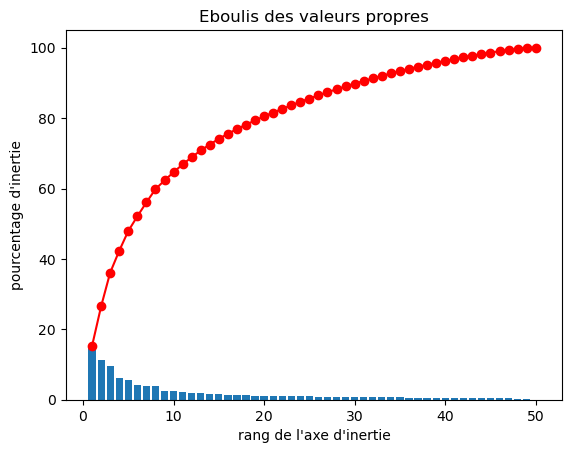

In [49]:
from sklearn.decomposition import PCA
pca = PCA(random_state=42)
pca.fit(X_train_scaled)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

display_scree_plot(pca)

In [50]:
var = 0.80

pca = PCA(n_components=var, random_state=42)
pca.fit(X_train_scaled)
X_train_transformed = pca.transform(X_train_scaled)
X_test_transformed = pca.transform(X_test_scaled)
print(f"Nombre de composantes principales avec {var*100}% de la variance expliquée : {pca.components_.shape[0]}")
print(f"Nous avons gardé {round((pca.components_.shape[0]/nb_dim)*100,0)}% des dimensions")

Nombre de composantes principales avec 80.0% de la variance expliquée : 20
Nous avons gardé 40.0% des dimensions


### Vectorisation des tags

In [51]:
from sklearn.preprocessing import MultiLabelBinarizer

classes = first_m_tags

mlb = MultiLabelBinarizer(classes=classes)
train_labels = mlb.fit_transform(y_train)
test_labels = mlb.transform(y_test)

print("Affichage des classes du modèle de vectorisation :")
print("-"*60)
display(mlb.classes_)

Affichage des classes du modèle de vectorisation :
------------------------------------------------------------


C:\Users\A475388\AppData\Local\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:895: UserWarning: unknown class(es) ['aadhaar', 'aapt', 'abaddressbook', 'abort', 'absolute', 'abstract', 'abstraction', 'acceleration', 'accelerometer', 'accent', 'accept', 'acceptance', 'access', 'accessibility', 'accessor', 'accessory', 'accessorytype', 'accompanist', 'accordion', 'account', 'accounting', 'accuracy', 'aceoledb', 'acid', 'acrobat', 'action', 'actionbar', 'actionbaractivity', 'actionbardrawertoggle', 'actioncable', 'actioncontroller', 'actionfilterattribute', 'actionlistener', 'actionmailer', 'actionmode', 'actionscript', 'actionview', 'activation', 'active', 'activeadmin', 'activejdbc', 'activejob', 'activemq', 'activerecord', 'activestorage', 'activiti', 'activity', 'activitynotfoundexception', 'actix', 'actor', 'actuator', 'acyclic', 'adaboost', 'adal', 'adam', 'adapter', 'adaptive', 'adblock', 'addeventlistener', 'addin', 'addins', 'addition', 'addon', 'addons', 'address', '

array(['python', 'android', 'java', 'javascript', 'spring', 'node',
       'core', 'angular', 'google', 'swift', 'studio', 'html', 'reactjs',
       'amazon', 'xcode', 'laravel', 'react', 'testing', 'django',
       'apache', 'typescript', 'json', 'docker', 'boot', 'visual',
       'panda', 'service', 'gradle', 'linux', 'window', 'framework',
       'jquery', 'data', 'spark', 'firebase', 'azure', 'http', 'selenium',
       'flutter', 'learning', 'server', 'unit', 'angularjs', 'ruby',
       'bootstrap', 'rest', 'array', 'database', 'dataframe', 'cloud'],
      dtype=object)

In [52]:
test_labels

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [53]:
df_test_labels = pd.DataFrame(test_labels)
df_test_labels.describe()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
count,5999.000000,5999.000000,5999.000000,5999.000000,5999.000000,5999.000000,5999.000000,5999.000000,5999.000000,5999.000000,...,5999.000000,5999.000000,5999.000000,5999.000000,5999.000000,5999.000000,5999.000000,5999.000000,5999.000000,5999.000000
mean,0.192699,0.105518,0.136523,0.166861,0.063177,0.067511,0.040340,0.037840,0.046341,0.051509,...,0.024171,0.024337,0.016669,0.013502,0.016669,0.019003,0.019503,0.016836,0.018003,0.019170
std,0.394451,0.307245,0.343371,0.372883,0.243302,0.250926,0.196772,0.190824,0.210240,0.221051,...,0.153592,0.154107,0.128040,0.115422,0.128040,0.136547,0.138297,0.128668,0.132973,0.137133
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [54]:
train_labels

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [55]:
df_train_labels = pd.DataFrame(train_labels)
df_train_labels.describe()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
count,23996.000000,23996.000000,23996.000000,23996.000000,23996.000000,23996.000000,23996.000000,23996.000000,23996.000000,23996.000000,...,23996.000000,23996.000000,23996.000000,23996.000000,23996.000000,23996.000000,23996.000000,23996.000000,23996.000000,23996.000000
mean,0.196449,0.107518,0.143107,0.157901,0.065261,0.062885,0.040298,0.038048,0.041674,0.051300,...,0.020628,0.024129,0.018503,0.012419,0.016044,0.020712,0.020253,0.019420,0.020753,0.014169
std,0.397321,0.309777,0.350189,0.364656,0.246991,0.242762,0.196662,0.191316,0.199846,0.220614,...,0.142140,0.153453,0.134765,0.110748,0.125649,0.142421,0.140869,0.137998,0.142561,0.118190
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Modélisations - ML

In [56]:
# Algo supervisés
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [57]:
X_train_transformed.shape

(23996, 20)

In [58]:
train_labels.shape

(23996, 50)

In [59]:
X_test_transformed.shape

(5999, 20)

In [60]:
test_labels.shape

(5999, 50)

#### KNN

In [61]:
%%time
knn_clf = OneVsRestClassifier(KNeighborsClassifier(), n_jobs=-1)
knn_clf.fit(X_train_transformed, train_labels)
knn_predictions = knn_clf.predict(X_test_transformed)
metrics_report("knn", test_labels, knn_predictions, models_performance)

------knn Model Metrics-----
CPU times: total: 1min 52s
Wall time: 14.9 s


{'knn': {'Accuracy': 0.12,
  'Precision': 0.56,
  'Recall': 0.22,
  'F1': 0.3,
  'Haming loss': 0.04,
  'Jaccard score': 0.12}}

#### SVM

In [62]:
%%time
svm_clf = OneVsRestClassifier(LinearSVC(), n_jobs=-1)
svm_clf.fit(X_train_transformed, train_labels)

svm_preds = svm_clf.predict(X_test_transformed)
metrics_report("svm", test_labels, svm_preds, models_performance)

C:\Users\A475388\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\A475388\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


------svm Model Metrics-----
CPU times: total: 578 ms
Wall time: 18.1 s


{'knn': {'Accuracy': 0.12,
  'Precision': 0.56,
  'Recall': 0.22,
  'F1': 0.3,
  'Haming loss': 0.04,
  'Jaccard score': 0.12},
 'svm': {'Accuracy': 0.08,
  'Precision': 0.45,
  'Recall': 0.14,
  'F1': 0.19,
  'Haming loss': 0.04,
  'Jaccard score': 0.05}}

#### Random Forest

In [63]:
%%time
rf_clf = OneVsRestClassifier(RandomForestClassifier(), n_jobs=-1)
rf_clf.fit(X_train_transformed, train_labels)
rf_preds = rf_clf.predict(X_test_transformed)
metrics_report("Random Forest", test_labels, rf_preds, models_performance)

C:\Users\A475388\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\A475388\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


------Random Forest Model Metrics-----
CPU times: total: 6.64 s
Wall time: 1min 18s


{'knn': {'Accuracy': 0.12,
  'Precision': 0.56,
  'Recall': 0.22,
  'F1': 0.3,
  'Haming loss': 0.04,
  'Jaccard score': 0.12},
 'svm': {'Accuracy': 0.08,
  'Precision': 0.45,
  'Recall': 0.14,
  'F1': 0.19,
  'Haming loss': 0.04,
  'Jaccard score': 0.05},
 'Random Forest': {'Accuracy': 0.1,
  'Precision': 0.66,
  'Recall': 0.15,
  'F1': 0.22,
  'Haming loss': 0.03,
  'Jaccard score': 0.07}}

#### Gradient boosting

In [64]:
%%time
gb_clf = OneVsRestClassifier(GradientBoostingClassifier(), n_jobs=-1)
gb_clf.fit(X_train_transformed, train_labels)
gb_preds = gb_clf.predict(X_test_transformed)
metrics_report("Gradient Boosting", test_labels, gb_preds, models_performance)

------Gradient Boosting Model Metrics-----
CPU times: total: 1.86 s
Wall time: 2min 11s


{'knn': {'Accuracy': 0.12,
  'Precision': 0.56,
  'Recall': 0.22,
  'F1': 0.3,
  'Haming loss': 0.04,
  'Jaccard score': 0.12},
 'svm': {'Accuracy': 0.08,
  'Precision': 0.45,
  'Recall': 0.14,
  'F1': 0.19,
  'Haming loss': 0.04,
  'Jaccard score': 0.05},
 'Random Forest': {'Accuracy': 0.1,
  'Precision': 0.66,
  'Recall': 0.15,
  'F1': 0.22,
  'Haming loss': 0.03,
  'Jaccard score': 0.07},
 'Gradient Boosting': {'Accuracy': 0.1,
  'Precision': 0.52,
  'Recall': 0.19,
  'F1': 0.27,
  'Haming loss': 0.04,
  'Jaccard score': 0.1}}

#### Résultats

In [65]:
result_df = pd.DataFrame.from_dict(models_performance, orient="index")
result_df

,Accuracy,Precision,Recall,F1,Haming loss,Jaccard score
knn,0.12,0.56,0.22,0.30,0.04,0.12
svm,0.08,0.45,0.14,0.19,0.04,0.05
Random Forest,0.10,0.66,0.15,0.22,0.03,0.07
Gradient Boosting,0.10,0.52,0.19,0.27,0.04,0.10
